In [ ]:
import requests
from lib.authenticate import bearer
import pandas as pd
from lib.epoch_time import epoch_to_datetime, date_to_epoch
import matplotlib.pyplot as plt
import numpy as np
import tulipy as ti
import urllib.parse
import sqlite3
from datetime import datetime, timedelta

[INFO]: Access token last updated: 2025-07-07 10:03:17 (expires in -1137 seconds)
[INFO]: Refresh token last updated: 2025-07-06 17:32:05 (expires in 7 days)
[INFO]: The access token has expired, updating automatically.
[INFO]: Access token updated: 2025-07-07 10:52:15.767755
[INFO]: Linked Accounts: [{'accountNumber': '59602680', 'hashValue': '3F4575C1F03A0A2DFE55356F0872FA3956469780FEDD669DFC5A62884E311A8C'}]
[INFO]: Initialization Complete


In [2]:
# Market Data API
market_url = "https://api.schwabapi.com/marketdata/v1/"

In [3]:
# Symbol formatting
def format_symbol (symbol_input):
    symbol = symbol_input.strip().upper()
    if symbol.startswith("/"):
        return urllib.parse.quote(symbol)
    return symbol

In [4]:
# def fetch_store_plot(symbol, start_date_str, end_date_str, plot=True):
#     """
#     Fetches historical market data for the given symbol and date range
#     by making multiple API calls (max 10 days each),
#     stores the concatenated data in a SQLite database,
#     and optionally plots the closing prices.

#     Parameters:
#     - symbol (str): ticker or futures symbol.
#     - start_date_str (str): start date in 'YYYYMMDD' format.
#     - end_date_str (str): end date in 'YYYYMMDD' format.
#     - plot (bool): whether to plot the data after fetching.

#     Returns:
#     - pd.DataFrame: full fetched price data.
#     """
#     start_date = datetime.strptime(start_date_str, "%Y%m%d")
#     end_date = datetime.strptime(end_date_str, "%Y%m%d")

#     # Function to generate date ranges (10 days max each)
#     def generate_date_ranges(start_date, end_date, step_days=10):
#         from datetime import timedelta
#         ranges = []
#         current_start = start_date
#         while current_start < end_date:
#             current_end = min(current_start + timedelta(days=step_days), end_date)
#             ranges.append((current_start, current_end))
#             current_start = current_end
#         return ranges

#     all_data = pd.DataFrame()

#     for start, end in generate_date_ranges(start_date, end_date):
#         print(f"Fetching data from {start.date()} to {end.date()} for {symbol}...")
#         chunk = get_price_history(symbol, start, end)  # make sure get_price_history is defined/imported
#         if chunk is not None:
#             all_data = pd.concat([all_data, chunk], ignore_index=True)

#     # Clean duplicates and reset index
#     all_data.drop_duplicates(subset=['datetime'], inplace=True)
#     all_data.reset_index(drop=True, inplace=True)

#     # Save to SQLite
#     conn = sqlite3.connect("schwab_data.db")
#     all_data.to_sql("price_data", conn, if_exists="replace", index=False)
#     conn.close()

#     print("Data fetched and stored to 'schwab_data.db' successfully.")

#     if plot and not all_data.empty:
#         fig, ax = plt.subplots(figsize=(12, 6))
#         ax.plot(all_data.index, all_data['close'])
#         all_data['date'] = all_data['datetime'].dt.date
#         unique_dates = all_data['date'].drop_duplicates()
#         first_indices = all_data.groupby('date').head(1).index

#         ax.set_xticks(first_indices)
#         ax.set_xticklabels(unique_dates, rotation=45)
#         plt.grid(True)
#         plt.tight_layout()
#         plt.title(f"Closing Prices for {symbol.upper()}")
#         plt.show()

#     return all_data

In [5]:
def generate_date_ranges(start_date, end_date, step_days=10):
    from datetime import timedelta
    ranges = []
    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + timedelta(days=step_days), end_date)
        ranges.append((current_start, current_end))
        current_start = current_end
    return ranges

In [6]:
def fetch_and_store_all_data(symbol, start_date, end_date):
    all_data = pd.DataFrame()
    for start, end in generate_date_ranges(start_date, end_date):
        print(f"Fetching data from {start.date()} to {end.date()}...")
        chunk = get_price_history(symbol, start, end)
        if chunk is not None:
            all_data = pd.concat([all_data, chunk], ignore_index=True)
    # Remove duplicates if any
    all_data.drop_duplicates(subset=['datetime'], inplace=True)
    all_data.reset_index(drop=True, inplace=True)

    # Save to SQLite
    conn = sqlite3.connect("schwab_data.db")
    all_data.to_sql("price_data", conn, if_exists="replace", index=False)
    conn.close()
    print("Data saved to database.")

In [7]:
def get_price_history(symbol, start_date, end_date, period_type="day", period=None, freq_type="minute", frequency=1, extended_hours="false"):
    endpoint = "pricehistory"

    start_epoch = int(start_date.timestamp()*1000)
    end_epoch = int(end_date.timestamp()*1000)
    symbol = format_symbol(symbol)

    if period is None:
        # set a default period based on period_type if needed
        period = 10

    params = {
        "symbol": symbol,
        "periodType": period_type,
        "period": period,
        "frequencyType": freq_type,
        "frequency": frequency,
        "startDate": start_epoch,
        "endDate": end_epoch,
        "needExtendedHoursData": extended_hours,
        "needPreviousClose": "true"
    }

    response = requests.get(f"{market_url}{endpoint}", params=params,
        headers={f"Authorization": f"Bearer {bearer}"})

    if response.status_code == 200:
        returned_data = response.json()
        if 'candles' in returned_data:
            for candle in returned_data['candles']:
                candle['datetime'] = epoch_to_datetime(candle['datetime'])
            return pd.DataFrame(returned_data['candles'])
        else:
            print("No candle data found.")
    else:
        print(f"Failed with status: {response.status_code}")
    return None

In [8]:
def main():
    symbol = input("Symbol: ")
    start_date = datetime.strptime(input("Start date (YYYYMMDD): "), "%Y%m%d")
    end_date = datetime.strptime(input("End date (YYYYMMDD): "), "%Y%m%d")

    # Example: fetch all data and store in DB
    fetch_and_store_all_data(symbol, start_date, end_date)

    # Optionally, load from DB and plot
    conn = sqlite3.connect("schwab_data.db")
    price_df = pd.read_sql("SELECT * FROM price_data ORDER BY datetime", conn, parse_dates=['datetime'])
    conn.close()

    if price_df is not None and not price_df.empty:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(price_df.index, price_df['close'])
        price_df['date'] = price_df['datetime'].dt.date
        unique_dates = price_df['date'].drop_duplicates()
        first_indices = price_df.groupby('date').head(1).index

        ax.set_xticks(first_indices)
        ax.set_xticklabels(unique_dates, rotation=45)

        plt.grid(True)
        plt.tight_layout()
        plt.show()

Fetching data from 2024-07-01 to 2024-07-11...
Fetching data from 2024-07-11 to 2024-07-21...
Fetching data from 2024-07-21 to 2024-07-31...
Fetching data from 2024-07-31 to 2024-08-10...
Fetching data from 2024-08-10 to 2024-08-20...
Fetching data from 2024-08-20 to 2024-08-30...
Fetching data from 2024-08-30 to 2024-09-09...
Fetching data from 2024-09-09 to 2024-09-19...
Fetching data from 2024-09-19 to 2024-09-29...
Fetching data from 2024-09-29 to 2024-10-09...
Fetching data from 2024-10-09 to 2024-10-19...
Fetching data from 2024-10-19 to 2024-10-29...
Fetching data from 2024-10-29 to 2024-11-08...
Fetching data from 2024-11-08 to 2024-11-18...
Fetching data from 2024-11-18 to 2024-11-28...
Fetching data from 2024-11-28 to 2024-12-08...
Fetching data from 2024-12-08 to 2024-12-18...
Fetching data from 2024-12-18 to 2024-12-28...
Fetching data from 2024-12-28 to 2025-01-07...
Fetching data from 2025-01-07 to 2025-01-17...
Fetching data from 2025-01-17 to 2025-01-27...
Fetching data

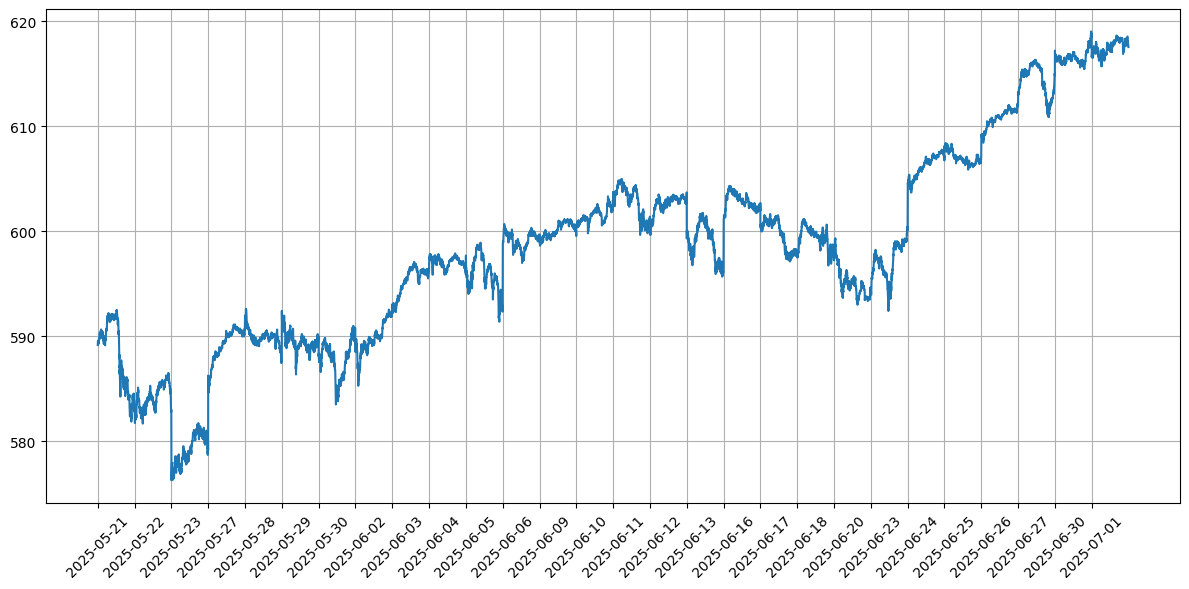

In [9]:
if __name__ == "__main__":
    main()

In [10]:
conn = sqlite3.connect("schwab_data.db")
df = pd.read_sql_query("SELECT * FROM price_data LIMIT 100", conn)  # adjust LIMIT as needed
print(df.head())
conn.close()


     open      high       low     close  volume             datetime
0  588.47  589.1800  588.4200  589.1799  554221  2025-05-21 06:30:00
1  589.17  589.5500  589.0100  589.4499  481699  2025-05-21 06:31:00
2  589.45  589.6987  589.3500  589.5700  225320  2025-05-21 06:32:00
3  589.56  589.6695  589.2793  589.5800  203124  2025-05-21 06:33:00
4  589.57  589.6700  589.2700  589.2900  141856  2025-05-21 06:34:00
